<a href="https://colab.research.google.com/github/joseorlandomx/topicodeindustria1/blob/main/Practica_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 2**

José Orlando Salas Contreras (208743738)

[jose.salas4373@alumnos.udg.mx](mailto:jose.salas4373@alumnos.udg.mx)

**Requisitos mínimos:**
* **Actividad 1:** Lévy distribution - N Curvas (3 pts)
* **Actividad 2:** Lévy distribution - Histograma + Curva (4 pts)
* **Actividad 3:** Lévy ﬂight - Vec2d - 1 Trayectoria (6 pts)
* **Actividad 4:** Correlated Random Walk - Vec2d - N Trayectorias (7 pts)

**Revisión de la práctica:**
* El notebook con la práctica se trabajará en **Google Colab** o la **IDE** de preferencia del estudiante y se entregará en un repositorio en **GitHub**. Será necesario demostrar por medio de commits el historial de versiones de su NoteBook.
* El estudiante deberá ser capaz de explicar su código y de corregir errores introducidos a este.

## **Modules**

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt # Gráficas 2D
import pandas as pd

from plotly.subplots import make_subplots # Para subgráficos
import plotly.graph_objects as go # Gráficos interactivos y 3D

from scipy.stats import wrapcauchy # Para ángulos
from scipy.stats import levy_stable # Levy Stable function

import pickle

## **Classes**

In [ ]:
# Nota: Esta clase la importaremos junto con el segundo bloque de modulos
################# http://www.pygame.org/wiki/2DVectorClass ##################
class Vec2d(object):
    """2d vector class, supports vector and scalar operators,
       and also provides a bunch of high level functions
       """
    __slots__ = ['x', 'y']

    def __init__(self, x_or_pair, y = None):
        if y == None:
            self.x = x_or_pair[0]
            self.y = x_or_pair[1]
        else:
            self.x = x_or_pair
            self.y = y

    # Addition
    def __add__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x + other.x, self.y + other.y)
        elif hasattr(other, "__getitem__"):
            return Vec2d(self.x + other[0], self.y + other[1])
        else:
            return Vec2d(self.x + other, self.y + other)

    # Subtraction
    def __sub__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x - other.x, self.y - other.y)
        elif (hasattr(other, "__getitem__")):
            return Vec2d(self.x - other[0], self.y - other[1])
        else:
            return Vec2d(self.x - other, self.y - other)

    # Vector length
    def get_length(self):
        return math.sqrt(self.x**2 + self.y**2)

    # rotate vector
    def rotated(self, angle):
        cos = math.cos(angle)
        sin = math.sin(angle)
        x = self.x*cos - self.y*sin
        y = self.x*sin + self.y*cos
        return Vec2d(x, y)

## **Actividad 1: Lévy distribution - N Curvas (3 pts)**
* Generar al menos las 4 curvas de distribución tipo Lévy stable que se observan en la imagen y graficarlas en una sola figura con **plotly**.
* Cada una de las curvas corresponde a un valor distinto de **alpha**.
* Considere los siguientes parametros para las curvas a generar: **m** = 3.0, **beta** = 0.

In [ ]:
# Inicializamos parámetros
resolution = 200 # Número de puntos a evaluar en el dominio
aux_domain = np.linspace(-np.pi, np.pi, resolution)
x = [0.5, 1.0, 1.5, 2.0] # Vector de exponentes para la distribución Lévy
beta = 0.0
m = 0.0

# Inicializamos la figura en Plotly
figura = go.Figure()

# Generamos las iteraciones de la distribución Lévy Stable
for exp in x:
  levy_pdf = levy_stable.pdf(aux_domain, exp, beta, m) # Calcula la función de densidad de probabilidad PDF
  trace = go.Scatter(x=aux_domain, y=levy_pdf, mode='lines', name=f'exponent')
  figura.add_trace(trace)

# Personalizamos la figura
figura.update_layout(
    title='Distribution Lévy Stable',
    xaxis_title = 'Tiempo',
    yaxis_title = 'Valor',
    showlegend = True
)

figura.show()


## **Actividad 2: Lévy distribution - Histograma + Curva (4 pts)**
* A partir de un conjunto de valores aleatorios extraidos de una distribución tipo Lévy Stable, obtener su histograma y comparar con la curva correspondiente PDF.
* Visualizar con **matplotlib**.

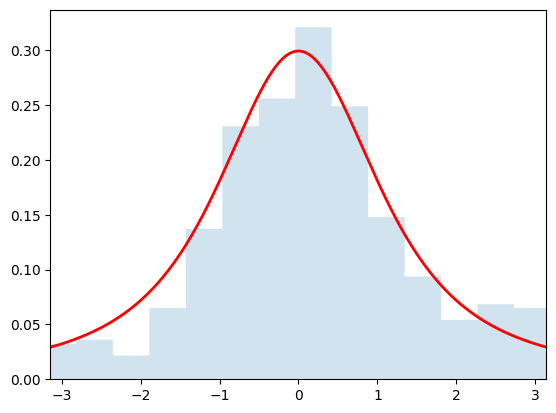

In [ ]:
# Inicializamos parámetros
levy_exponent = 1.2
beta = 0
resolution = 600 # Puntos a evaluar

# Definimos el dominio a evaluar la distribución de valores
aux_domain = np.linspace(-np.pi, np.pi, resolution)

# Inicializamos la figura
plt_figure = plt.figure()

# Añadimos un subplot para el histograma, 111 significa fila, columna y peso abajo del plot principal de la figura
subplot = plt_figure.add_subplot(111)

# Obtenemos la distribución PDF con Lévy Stable
levy_pdf = np.array([levy_stable.pdf(i, levy_exponent, beta) for i in aux_domain])

# Generamos datos aleatorios con levy_stable.rvs
levy_data = levy_stable.rvs(levy_exponent, beta, size=resolution)

# Configuramos el subplot, pasamos los datos de la densidad de probabilidad y creamos el histograma
subplot.set_xlim(aux_domain[0], aux_domain[-1])
subplot.plot(aux_domain, levy_pdf, lw=2, label='Curva pdf Lévy Stable', color="red")
subplot.hist(levy_data, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='Histograma')

# Personalizamos las leyendas y títulos de los ejes
plt.title=('Curva PDF Lévy Stable')
plt.xlabel=('Valor')
plt.ylabel=('Densidad')

## **Actividad 3: Lévy flight - Vec2d - 1 Trayectoria (6 pts)**
* Generar una trayectoria tipo Lévy.
* Utilizar **Vec2d**.
* Guardar trayectoria en **pandas** Data Frame.
* Visualizar proyección en 3D con **plotly**.

In [ ]:
# Inicializamos parámetros
n_steps = 1000 # Número total de pasos
cauchy_param = 0.6 # Dirección del siguiente paso en la distribución Cauchy
levy_alpha = 1.2 # Variabilidad de la longitud del paso
beta = 0
std_steps = 2 # Desviación estándar
vel = 4 # Velocidad inicial

# Inicializamos el vector de velocidad
initial_velocity = Vec2d(vel, 0)

# Creamos el DataFrame para X y Y
trajectory_df = pd.DataFrame(columns=['x_pos', 'y_pos'])
temp_df = pd.DataFrame([{'x_pos': 0, 'y_pos': 0}])
trajectory_df = pd.concat([trajectory_df, temp_df], ignore_index=True)

# Generamos la trayectoria Lévy Flight
step_index = 1
while step_index < n_steps:
    angle = wrapcauchy.rvs(c=cauchy_param)
    current_velocity = initial_velocity.rotated(angle)
    n_substeps = int(abs(levy_stable.rvs(alpha=levy_alpha, beta=beta, loc=std_steps)))

    if step_index + n_substeps > n_steps:
        n_substeps = n_steps - step_index

    substep_count = 0
    while substep_count < n_substeps:
        temp_df = pd.DataFrame([{
            'x_pos': trajectory_df.x_pos[step_index - 1] + current_velocity.x,
            'y_pos': trajectory_df.y_pos[step_index - 1] + current_velocity.y
        }])
        trajectory_df = pd.concat([trajectory_df, temp_df], ignore_index=True)
        substep_count += 1
        step_index += 1

# Creación del gráfico en 3D
fig = go.Figure(data=go.Scatter3d(
    x=trajectory_df.x_pos,
    y=trajectory_df.y_pos,
    z=np.linspace(0, 1, n_steps),
    line=dict(width=3),
    name='Trayectoria',
    showlegend=True,
    mode='lines'
))

# Personalizamos el título y los ejes
fig.update_layout(
    title='Trayectoria Lévy Flight',
    xaxis_title='X',
    yaxis_title='Y',
    scene_zaxis_title='Tiempo'
)

# Mostramos la figura
fig.show()


## **Actividad 4: Correlated Random Walk - Vec2d - N Trayectorias (7 pts)**
* Generar tantas trayectorias tipo CRW como se especifique en una variable de control **n_traj**.
* Cada una de las trayectorias debera tener un coeficiente de Cauchy diferente.
Utilizar Vec2d.
* Guardar trayectorias en **pandas** Data Frame.
* Visualizar proyección en 3D con **plotly**.
* Exportar trayectorias a un archivo tipo **pkl**.

In [21]:
# Inicializamos parámetros
n_trajectories = 4
n_steps = 500
std_cauchy = 0.4
lvw_alpha = 1.2
beta = 0
std_steps = 3
speed = 6

# DataFrame para las trayectorias y figura Plotly
all_trajectories_df = pd.DataFrame(columns=['x_pos', 'y_pos', 'trajectory_id'])

# Inicializamos la figura
fig = go.Figure()

# Rango para el eje Z
aux_zdomain = np.linspace(0, 1, n_steps)

for trajectory_id in range(n_trajectories):
  # Vector de velocidad y almacenamiento de la trayectoria actual
  velocity = Vec2d(speed, 0)

  current_trajectory_df = pd.DataFrame(columns=['x_pos', 'y_pos'])

  # Posición inicial
  current_trajectory_df = pd.concat([current_trajectory_df, pd.DataFrame([{'x_pos': 0, 'y_pos': 0}])])

  step_index = 1

  while step_index < n_steps:
    # Ángulo del paso actual
    angle = wrapcauchy.rvs(c=std_cauchy)
    velocity = velocity.rotated(angle)

    # Longitud del paso actual
    step_length = abs(math.floor(levy_stable.rvs(alpha=lvw_alpha, beta=beta, loc=std_steps)))

    if step_index + step_length > n_steps:
      step_length = n_steps - step_index

    substep_count = 0

    while substep_count < step_length:
      new_position = pd.DataFrame([{
          'x_pos': current_trajectory_df.x_pos[step_index - 1] + velocity.x,
          'y_pos': current_trajectory_df.y_pos[step_index - 1] + velocity.y
      }])

      current_trajectory_df = pd.concat([current_trajectory_df, new_position], ignore_index=True)
      substep_count += 1
      step_index += 1

  # Identificador de la trayectoria
  current_trajectory_df['trajectory_id'] = trajectory_id

  # Trayectoria actual del Data Frame
  all_trajectories_df = pd.concat([all_trajectories_df, current_trajectory_df], ignore_index=True)

  # Configuramos el Gráfico en 3D
  fig.add_trace(go.Scatter3d(
      x = current_trajectory_df.x_pos,
      y = current_trajectory_df.y_pos,
      z = aux_zdomain,
      line = dict(width=3),
      name = f'Trayectoria {trajectory_id}',
      showlegend = True,
      mode = 'lines'
  ))

# Trayectorias en archivos pickle
for trajectory_id in range(n_trajectories):
  current_trajectory = all_trajectories_df[all_trajectories_df['trajectory_id'] == trajectory_id]
  current_trajectory.to_pickle(f'./trayectoria_{trajectory_id}.pkl')

# Personalización y visualización del gráfico
fig.update_layout(
    title = 'Trayectorias',
    xaxis_title = 'X',
    yaxis_title = 'Y',
    scene_zaxis_title = 'Tiempo'
)

fig.show()
